# Imports

Unable to obtain the Attention and SelfAttention layers

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy.stats as st
import sys
import os
import random
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Conv2D, Lambda, Input, Bidirectional, Flatten
from tensorflow.keras import optimizers, backend as K
# from layers import Attention, SelfAttention

In [2]:
print(tf.__version__)

2.16.1


# TensorFlow session settings, specifically focusing on thread management

In [3]:
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= '1'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

# Model architecture

This model architecture is designed to process sequential data with both convolutional and recurrent layers, leveraging the strength of CNNs in capturing local patterns and the strength of LSTMs in capturing long-term dependencies. The dropout layer helps in regularization, and the final dense layer with softmax activation provides the classification output.

In [4]:
def model(x_train, num_labels, LSTM_units, dropout, num_conv_filters, batch_size):
    """
    x_train: A sample input used to determine the input shape for the model.
    num_labels: The number of classes or output labels. This determines the number of neurons in the final dense layer.
    LSTM_units: The number of units in the LSTM layer, which controls the capacity of the LSTM to learn long-term dependencies.
    dropout: The dropout rate, which helps in regularization to prevent overfitting.
    num_conv_filters: The number of convolutional filters, which determine how many different patterns the CNN layer will learn.
    batch_size: The number of samples processed at a time during training. This is used to set the shape of the input layer.
    """

    """
    Baseline model with a CNN layer and LSTM RNN layer.
    Inputs:
    - x_train: required for creating input shape for RNN layer in Keras
    - num_labels: number of output classes (int)
    - LSTM_units: number of RNN units (int)
    - dropout: dropout rate (float)
    - num_conv_filters: number of CNN filters (int)
    - batch_size: number of samples to be processed in each batch
    Returns
    - model: A Keras model
    """
    cnn_inputs = Input(batch_shape=(batch_size, x_train.shape[1], x_train.shape[2], 1), name='rnn_inputs')
    """
    Input: Defines the input shape for the model.
    batch_shape: The shape is (batch_size, time_steps, features, 1). Here, time_steps could be the number of time steps in a 
    time series or the number of words in a sequence, and features is the dimensionality of the features at each time step.
    The last dimension, 1, indicates a single channel, which is typical for monochromatic data (e.g., grayscale images or 
    single-feature sequences).
    """
    cnn_layer = Conv2D(num_conv_filters, kernel_size = (1, x_train.shape[2]), strides=(1, 1), padding='valid', data_format="channels_last")
    cnn_out = cnn_layer(cnn_inputs)
    """
    Conv2D: Applies a 2D convolution over the input.
    num_conv_filters: The number of filters (kernels) used, which also determines the output's depth.
    kernel_size: (1, x_train.shape[2]) means each filter is of height 1 and spans all features in width, 
    effectively capturing patterns across the full feature set at each time step.
    strides: The filter moves 1 step at a time in both directions.
    padding='valid': No padding, so the output size is reduced compared to the input size.
    data_format="channels_last": Specifies that the channel dimension is the last dimension in the input shape.
    """

    sq_layer = Lambda(lambda x: K.squeeze(x, axis = 2))
    sq_layer_out = sq_layer(cnn_out)
    """
    Lambda: A layer that wraps a custom operation, here it uses K.squeeze.
    K.squeeze: Removes the dimension with index 2, which is the height dimension in the CNN output that has been reduced to 1. 
    The result is that the data is reshaped from (batch_size, time_steps, 1, num_filters) to (batch_size, time_steps, num_filters).
    """

    rnn_layer = LSTM(LSTM_units, return_sequences=False, name='lstm') #return_state=True
    rnn_layer_output = rnn_layer(sq_layer_out)
    """
    LSTM: A type of recurrent neural network (RNN) layer that can capture temporal dependencies.
    LSTM_units: Number of LSTM cells, which controls the capacity of the LSTM to learn features.
    return_sequences=False: The LSTM returns only the last output in the output sequence. If True, 
    it would return the full sequence.
    This layer processes the squeezed output from the CNN, adding the capability to learn sequential patterns and dependencies.
    """

    dropout_layer = Dropout(rate = dropout)
    dropout_layer_output = dropout_layer(rnn_layer_output)
    """
    Dropout: A regularization technique where a fraction of neurons is randomly set to zero during training to prevent overfitting.
    rate=dropout: Specifies the dropout rate, i.e., the fraction of input units to drop.
    """

    dense_layer = Dense(num_labels, activation = 'softmax')
    dense_layer_output = dense_layer(dropout_layer_output)
    """
    Dense: A fully connected layer where each input is connected to each output.
    num_labels: The number of output neurons, which corresponds to the number of classes in a classification task.
    activation='softmax': The softmax activation function is used for multi-class classification. It outputs a 
    probability distribution over the classes.
    """

    model = Model(inputs=cnn_inputs, outputs=dense_layer_output)
    print (model.summary())
    """
    Model: Combines the input and output layers into a Keras model.
    inputs: The starting point of the model, defined by cnn_inputs.
    outputs: The endpoint of the model, defined by dense_layer_output.
    model.summary(): Prints a summary of the model architecture, including the number of parameters in each layer and the 
    total number of parameters.
    """

    return model

# Hyperparameters and Configurations

| **Parameter**   | **Description**                                                                                             |
|-----------------|-------------------------------------------------------------------------------------------------------------|
| **EPOCH**       | Specifies how many times the entire dataset is passed through the model during training to allow the model to learn from the data. |
| **BATCH_SIZE**  | Defines the number of samples processed before the model’s weights are updated, balancing training efficiency and stability. |
| **LSTM_UNITS**  | Sets the number of units in the LSTM layer, influencing the model's capacity to learn temporal dependencies. |
| **CNN_FILTERS** | Determines the number of convolutional filters in the CNN layer, affecting the range of features detected from the input data. |
| **LEARNING_RATE** | Controls the step size for weight adjustments during optimization, impacting the convergence speed and stability of training. |
| **PATIENCE**    | Specifies the number of epochs to wait before stopping training if no improvement in validation performance is observed, helping prevent overfitting. |
| **SEED**        | Sets the random seed to ensure that the results of training are reproducible across different runs. |
| **DROPOUT**     | Indicates the fraction of input units to be randomly dropped during training, used for regularization to prevent overfitting. |


In [5]:
EPOCH = 10
BATCH_SIZE = 16
LSTM_UNITS = 32 
CNN_FILTERS = 3
LEARNING_RATE = 0.001
PATIENCE = 20
SEED = 0
DROPOUT = 0.1

## Reproducability

In [6]:
SEED = 0 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Save configs

### `BASE_DIR`

Constructs a directory path by concatenating `'./data/'` with the value of `MODE`, resulting in a path like `'./data/LOTO/'`. This directory is likely where the data files are stored.

### `SAVE_DIR`

Constructs a directory path for saving model results by concatenating `'./model_baseline_'` with the value of `MODE`, and appending `'_results'`. This will create a path like `'./model_baseline_LOTO_results'`, where the results of the model will be saved.


In [7]:
# DATA_FILES = [ 'WISDM.npz' ]
# MODE = 'LOTO'
# BASE_DIR = r'D:\00 Work folder Dissertation\01 Code trials\04 ConvLSTM code study\encodingHumanActivity\data\LOTO'
# SAVE_DIR = './model_baseline_' + MODE + '_results'

# Loading the NPZ file

It's a special type of dictionary-like object in NumPy that contains the arrays saved in the file.


In [8]:
data_input_file = r'D:\00 Work folder Dissertation\01 Code trials\04 ConvLSTM code study\encodingHumanActivity\data\LOTO\WISDM.npz'
tmp = np.load(data_input_file, allow_pickle=True)

In [9]:
keys = tmp.keys()
print(keys)

# Retrieve arrays using the keys
X = tmp['X']        # Typically features or input data
y_one_hot = tmp['y'] # Typically labels or target values
folds = tmp['folds'] # Potentially cross-validation folds or data splits

# Print shapes or inspect the arrays
print("Shape of X:", X.shape)
print("Shape of y:", y_one_hot.shape)
print("Shape of folds:", folds.shape)

KeysView(NpzFile 'D:\\00 Work folder Dissertation\\01 Code trials\\04 ConvLSTM code study\\encodingHumanActivity\\data\\LOTO\\WISDM.npz' with keys: y, X, folds)
Shape of X: (20846, 1, 100, 3)
Shape of y: (20846, 6)
Shape of folds: (10, 2)


## Shape of X
Shape of X: (20846, 1, 100, 3) <br>
**( Samples, Channels, Window size or steps, Number of features)**

- 20846 Samples are present in the data X
- Number of Channels/Sequences: In this context, it likely represents a single channel or sequence per sample. In many time-series or sequential datasets, this might be used to represent one time-series or sensor channel per sample.
- 100 is the Window - Sequence Length/Time Steps: This dimension corresponds to the length of each sequence or time window in the dataset. It means each sample is represented by a sequence of 100 time steps or frames.
- 3 is the Number of Features (x , y , z) values in each sample

In [10]:
X = np.squeeze(X, axis = 1)
X.shape

(20846, 100, 3)

The channels is removed here. Maybe because we only have one channel and this shape is preferable for the CNN model

## Shape of y

Shape of y: (20846, 6) <br>**(Number of samples, One hot encoded classes 6 of them)**

In [11]:
# Assuming y is loaded as an array
unique_labels = np.unique(y_one_hot, axis=0)

# Number of unique class vectors (i.e., number of classes)
NUM_LABELS = unique_labels.shape[0]

print("Number of classes:", NUM_LABELS)
print(unique_labels)

Number of classes: 6
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


## Shape of folds

Shape of folds: (10, 2) <br>**(Number of folds, 2 arrays representing a single fold)**<br> First array gives the indices of the entire dataset, second array indicates to which index its mapped to. 

Maybe first array contains indices for train dataset, second contains test dataset.
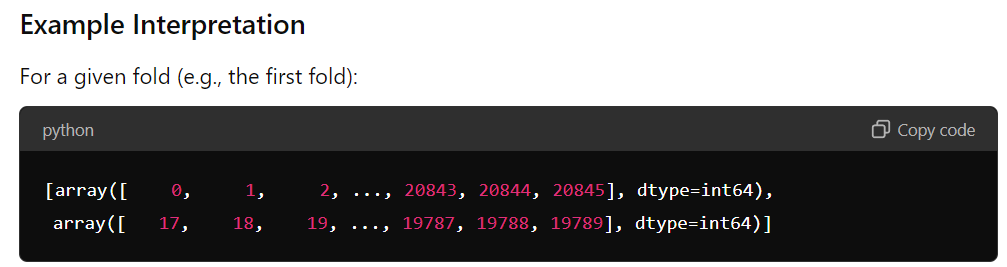

In [12]:
print(folds[0])

[array([    0,     1,     2, ..., 20843, 20844, 20845], dtype=int64)
 array([   17,    18,    19, ..., 19787, 19788, 19789], dtype=int64)]


# Initializing metrics

In [13]:
avg_acc = []
avg_recall = []
avg_f1 = []

In [16]:
early_stopping_epoch_list = []
y = np.argmax(y_one_hot, axis=1) #this will return the index of the maximum value along each row
y.shape #Basically y is not flattened into a one dimensional vector

(20846,)

# Trial without cross validation

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
y_train_one_hot = np.eye(NUM_LABELS)[y_train]
y_test_one_hot = np.eye(NUM_LABELS)[y_test]

In [18]:
X_train_ = np.expand_dims(X_train, axis=3)
X_test_ = np.expand_dims(X_test, axis=3)

In [20]:
train_trailing_samples = X_train_.shape[0] % BATCH_SIZE
test_trailing_samples = X_test_.shape[0] % BATCH_SIZE

if train_trailing_samples != 0:
    X_train_ = X_train_[0:-train_trailing_samples]
    y_train_one_hot = y_train_one_hot[0:-train_trailing_samples]
    y_train = y_train[0:-train_trailing_samples]
if test_trailing_samples != 0:
    X_test_ = X_test_[0:-test_trailing_samples]
    y_test_one_hot = y_test_one_hot[0:-test_trailing_samples]
    y_test = y_test[0:-test_trailing_samples]

print(y_train.shape, y_test.shape)

(16672,) (4160,)


In [21]:
rnn_model = model(x_train=X_train_, num_labels=NUM_LABELS, LSTM_units=LSTM_UNITS, dropout=DROPOUT, num_conv_filters=CNN_FILTERS, batch_size=BATCH_SIZE)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_inputs (InputLayer)         │ (16, 100, 3, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 100, 1, 3)        │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (16, 100, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (16, 32)               │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (16, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 6)                │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,818 (18.82 KB)

 Trainable params: 4,818 (18.82 KB)

 Non-trainable params: 0 (0.00 B)

None
